In [21]:
import os
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

# Check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 12
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2
IMG_HEIGHT = 32
IMG_WIDTH = 128
NUM_WORKERS = 2

# Character mapping
characters = string.ascii_letters + string.digits
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for i, c in enumerate(characters)}
VOCAB_SIZE = len(characters) + 1  # +1 for blank token for CTC
MAX_LABEL_LENGTH = 6


# Dataset
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = [os.path.splitext(os.path.basename(f))[0] for f in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_str = self.labels[idx]
        label = [char_to_idx[c] for c in label_str]

        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        label_tensor = torch.full((MAX_LABEL_LENGTH,), -1, dtype=torch.long)
        label_tensor[:len(label)] = torch.tensor(label, dtype=torch.long)
        return image, label_tensor


# Fast CRNN Model (ResNet18 + BiLSTM)
class FastCRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(*list(resnet.children())[:-3])  # Output: [B, 256, 4, 16] if input is 128x32

        self.lstm_input_size = 128 * (IMG_HEIGHT // 8)  # 256 * 4
        self.rnn = nn.LSTM(self.lstm_input_size, 256, num_layers=2, bidirectional=True, dropout=0.1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # [B, 256, 4, 16]
        x = x.permute(3, 0, 1, 2)  # [W, B, C, H]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [W, B, C*H]
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x  # [W, B, num_classes]

Using device: cuda


In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sandeep1507/captchaimgdata")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/captchaimgdata


In [24]:
def train_model(model, train_loader, val_loader, optimizer, epochs):
    model.to(device)
    criterion = nn.CTCLoss(blank=VOCAB_SIZE - 1, zero_infinity=True)
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)  # [W, B, C]
                outputs = F.log_softmax(outputs, dim=2)
                input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long).to(device)
                target_lengths = (labels != -1).sum(dim=1)
                loss = criterion(outputs, labels, input_lengths, target_lengths)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

            # Compute sequence-level accuracy
            _, preds = outputs.max(2)              # [W, B]
            preds = preds.permute(1, 0)            # [B, W]

            for i in range(images.size(0)):
                pred_seq = preds[i].cpu().numpy().tolist()
                pred_str = ''.join([idx_to_char[p] for p, _ in groupby(pred_seq) if p != VOCAB_SIZE - 1])
                true_str = ''.join([idx_to_char[c.item()] for c in labels[i] if c.item() != -1])
                if pred_str == true_str:
                    train_correct += 1
                train_total += 1

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # ------------------ Validation -------------------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                outputs = F.log_softmax(outputs, dim=2)
                input_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long).to(device)
                target_lengths = (labels != -1).sum(dim=1)
                loss = criterion(outputs, labels, input_lengths, target_lengths)
                val_loss += loss.item()

                _, preds = outputs.max(2)
                preds = preds.permute(1, 0)

                for i in range(images.size(0)):
                    pred_seq = preds[i].cpu().numpy().tolist()
                    pred_str = ''.join([idx_to_char[p] for p, _ in groupby(pred_seq) if p != VOCAB_SIZE - 1])
                    true_str = ''.join([idx_to_char[c.item()] for c in labels[i] if c.item() != -1])
                    if pred_str == true_str:
                        val_correct += 1
                    val_total += 1

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"\nEpoch {epoch} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Seq Acc: {train_acc:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f}, Val Seq Acc:   {val_acc:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies


    
    # Initialize model and optimizer
model = FastCRNN(num_classes=VOCAB_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, EPOCHS
)

# Save the trained model
torch.save(model.state_dict(), "fast_crnn_captcha_model.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/2434565135.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/12 - Training:   0%|          | 0/654 [00:00<?, ?it/s]/tmp/ipykernel_31/2434565135.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 - Validation: 100%|████████


Epoch 1 Summary:
Train Loss: 1.1002, Train Seq Acc: 0.3835
Val Loss:   0.4804, Val Seq Acc:   0.4861



Epoch 2 - Validation: 100%|██████████| 164/164 [00:04<00:00, 36.82it/s]



Epoch 2 Summary:
Train Loss: 0.1601, Train Seq Acc: 0.8402
Val Loss:   0.1196, Val Seq Acc:   0.8434



Epoch 3 - Validation: 100%|██████████| 164/164 [00:04<00:00, 35.79it/s]



Epoch 3 Summary:
Train Loss: 0.0774, Train Seq Acc: 0.9060
Val Loss:   0.0597, Val Seq Acc:   0.9398



Epoch 4 - Validation: 100%|██████████| 164/164 [00:04<00:00, 38.34it/s]



Epoch 4 Summary:
Train Loss: 0.0526, Train Seq Acc: 0.9318
Val Loss:   0.0473, Val Seq Acc:   0.9423



Epoch 5 - Validation: 100%|██████████| 164/164 [00:04<00:00, 38.63it/s]



Epoch 5 Summary:
Train Loss: 0.0309, Train Seq Acc: 0.9577
Val Loss:   0.0388, Val Seq Acc:   0.9507



Epoch 6 - Validation: 100%|██████████| 164/164 [00:04<00:00, 37.89it/s]



Epoch 6 Summary:
Train Loss: 0.0235, Train Seq Acc: 0.9665
Val Loss:   0.0351, Val Seq Acc:   0.9553



Epoch 7 - Validation: 100%|██████████| 164/164 [00:04<00:00, 38.76it/s]



Epoch 7 Summary:
Train Loss: 0.0330, Train Seq Acc: 0.9535
Val Loss:   0.0430, Val Seq Acc:   0.9425



Epoch 8 - Validation: 100%|██████████| 164/164 [00:04<00:00, 39.84it/s]



Epoch 8 Summary:
Train Loss: 0.0342, Train Seq Acc: 0.9512
Val Loss:   0.0387, Val Seq Acc:   0.9490



Epoch 9 - Validation: 100%|██████████| 164/164 [00:04<00:00, 40.23it/s]



Epoch 9 Summary:
Train Loss: 0.0262, Train Seq Acc: 0.9611
Val Loss:   0.0193, Val Seq Acc:   0.9784



Epoch 10 - Validation: 100%|██████████| 164/164 [00:04<00:00, 36.97it/s]



Epoch 10 Summary:
Train Loss: 0.0225, Train Seq Acc: 0.9650
Val Loss:   0.0517, Val Seq Acc:   0.9319



Epoch 11 - Validation: 100%|██████████| 164/164 [00:04<00:00, 35.85it/s]



Epoch 11 Summary:
Train Loss: 0.0330, Train Seq Acc: 0.9491
Val Loss:   0.0246, Val Seq Acc:   0.9646



Epoch 12 - Validation: 100%|██████████| 164/164 [00:04<00:00, 36.63it/s]



Epoch 12 Summary:
Train Loss: 0.0192, Train Seq Acc: 0.9706
Val Loss:   0.0257, Val Seq Acc:   0.9685



In [4]:
pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Seq Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Seq Accuracy")
    plt.title("Sequence Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
from itertools import groupby

def to_text(tensor):
    """Convert model output tensor to decoded string (CTC collapsed)."""
    sequence = tensor.cpu().numpy().tolist()
    return ''.join([idx_to_char[idx] for idx, _ in groupby(sequence) if idx != VOCAB_SIZE - 1])
def sequence_accuracy(preds, targets):
    correct = 0
    total = 0
    for pred, target in zip(preds, targets):
        pred_text = to_text(pred)
        true_text = ''.join([idx_to_char[c.item()] for c in target if c.item() != -1])
        if pred_text == true_text:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0.0
def character_accuracy(preds, targets):
    correct = 0
    total = 0
    for pred, target in zip(preds, targets):
        pred_text = to_text(pred)
        true_text = ''.join([idx_to_char[c.item()] for c in target if c.item() != -1])
        min_len = min(len(pred_text), len(true_text))
        correct += sum(p == t for p, t in zip(pred_text[:min_len], true_text[:min_len]))
        total += len(true_text)
    return correct / total if total > 0 else 0.0
import editdistance

def edit_distance(preds, targets):
    total_dist = 0
    for pred, target in zip(preds, targets):
        pred_text = to_text(pred)
        true_text = ''.join([idx_to_char[c.item()] for c in target if c.item() != -1])
        total_dist += editdistance.eval(pred_text, true_text)
    return total_dist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(preds, targets):
    y_true = []
    y_pred = []

    for pred, target in zip(preds, targets):
        pred_text = to_text(pred)
        true_text = ''.join([idx_to_char[c.item()] for c in target if c.item() != -1])
        min_len = min(len(pred_text), len(true_text))
        y_true += list(true_text[:min_len])
        y_pred += list(pred_text[:min_len])

    labels = sorted(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Character-Level Confusion Matrix")
    plt.show()
def visualize_predictions(model, dataloader, max_samples=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = F.log_softmax(outputs, dim=2)
            preds = outputs.argmax(dim=2).permute(1, 0)

            for i in range(images.size(0)):
                if images_shown >= max_samples:
                    plt.tight_layout()
                    plt.show()
                    return
                img = images[i].cpu().permute(1, 2, 0).squeeze()
                pred_text = to_text(preds[i])
                true_text = ''.join([idx_to_char[c.item()] for c in labels[i] if c.item() != -1])

                plt.subplot(1, max_samples, images_shown + 1)
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                plt.title(f"T: {true_text}\nP: {pred_text}", fontsize=8)
                images_shown += 1
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            outputs = F.log_softmax(outputs, dim=2)
            preds = outputs.argmax(dim=2).permute(1, 0)  # [B, W]

            all_preds.extend(preds.cpu())
            all_targets.extend(labels.cpu())

    return all_preds, all_targets


Character Accuracy: 0.9890
Sequence Accuracy: 0.9685
Total Edit Distance: 198


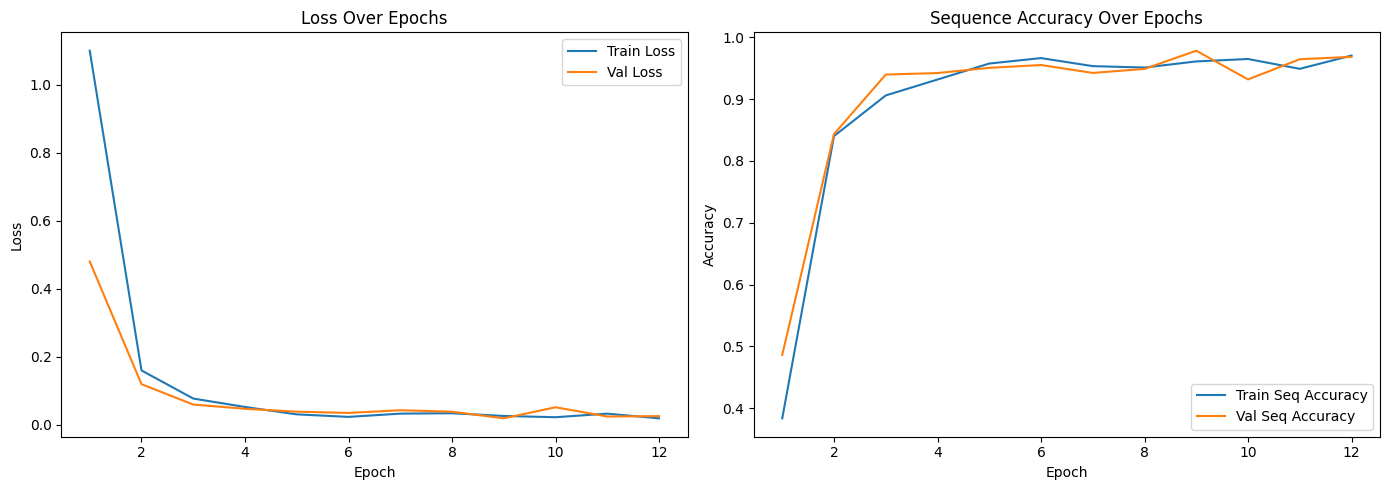

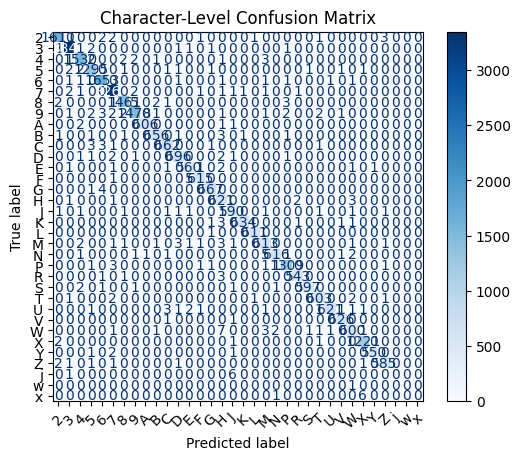

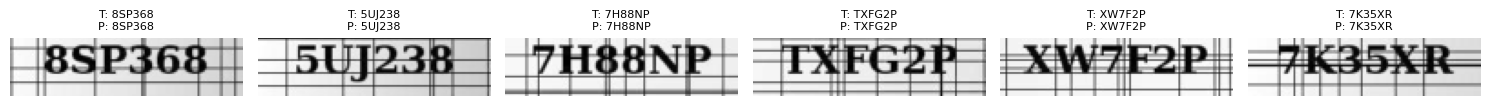

In [32]:
val_preds, val_targets = get_predictions_and_labels(model, val_loader)

# Metrics
print(f"Character Accuracy: {character_accuracy(val_preds, val_targets):.4f}")
print(f"Sequence Accuracy: {sequence_accuracy(val_preds, val_targets):.4f}")
print(f"Total Edit Distance: {edit_distance(val_preds, val_targets)}")

# Plots
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(val_preds, val_targets)
visualize_predictions(model, val_loader)


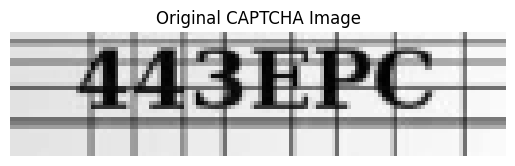

True : 443EPC
Pred : 443EPC
Correct Characters: 6/6


In [33]:
from itertools import groupby

def to_text(pred_tensor):
    pred_indices = pred_tensor.cpu().numpy().tolist()
    result = ''.join([idx_to_char[idx] for idx, _ in groupby(pred_indices) if idx != VOCAB_SIZE - 1])
    return result

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        X_single = X[0]
        y_single = y[0]

        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)

        pred_text = to_text(pred)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        correct_chars = sum(p == t for p, t in zip(pred_text, true_text))
        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        print(f"Correct Characters: {correct_chars}/{len(true_text)}")
        break
